Uncomment to install `astropy` and `sep`

In [1]:
# ! pip install astropy
# ! pip install sep

In [2]:
import sep
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
file_path = './Data/MAST_2025-06-08T1833/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
hdul = fits.open(file_path)

In [4]:
# print info
print(hdul.info())

Filename: ./Data/MAST_2025-06-08T1833/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        75   (14339, 8582)   float32   
  2  ERR           1 ImageHDU        10   (14339, 8582)   float32   
  3  CON           1 ImageHDU        10   (14339, 8582, 6)   int32   
  4  WHT           1 ImageHDU         9   (14339, 8582)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (14339, 8582)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (14339, 8582)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (14339, 8582)   float32   
  8  HDRTAB        1 BinTableHDU    532   160R x 261C   [23A, 5A, 3A, 45A, 6A, 13A, 7A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 32A, 21A, 3A, 3A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 23A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 8A, 8A, 5A, D, D, D,

In [5]:
# access the "science" image data
sci_data = hdul['sci'].data
sci_data = sci_data.astype(np.float32)

In [6]:
hdul.close()

Data surface look

In [7]:
print(np.shape(sci_data))
print("NaNs in SCI:", np.isnan(sci_data).sum(), "/", sci_data.size)
print(f"Max: {np.nanmax(sci_data)}")
print(f"Min: {np.nanmin(sci_data)}")

(8582, 14339)
NaNs in SCI: 4461608 / 123057298
Max: 5704.06201171875
Min: -3.2904701232910156


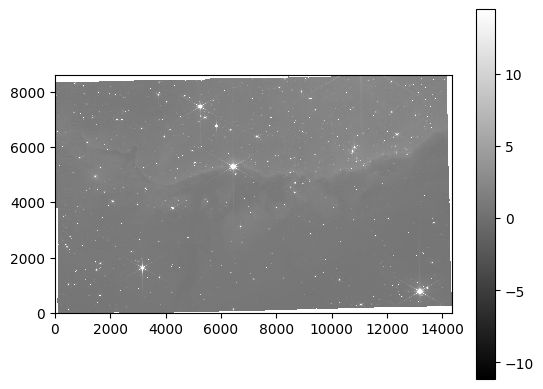

In [8]:
# show the image
# plt.figure(figsize=(10, 10))
m, s = np.nanmean(sci_data), np.nanstd(sci_data)
plt.imshow(sci_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

# plt.savefig('./sep-tutorial-figures/fits_image.png', bbox_inches='tight')
plt.show()

In [9]:
sci_data = sci_data.astype(np.float32)

In [10]:
# measure a spatially varying background on the image
bkg = sep.Background(sci_data)

In [11]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

1.1997147798538208
0.06582547724246979


In [12]:
bkg_image = np.array(bkg)

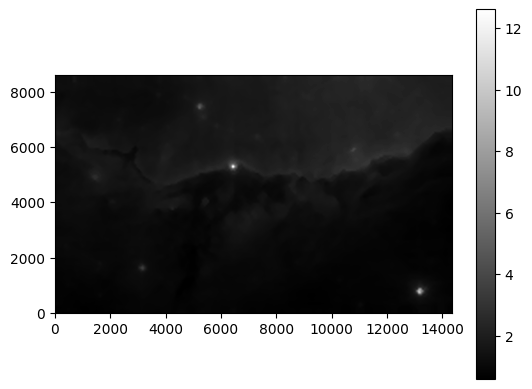

In [13]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

# plt.savefig('./sep-tutorial-figures/background_image.png', bbox_inches='tight')
plt.show()

In [14]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

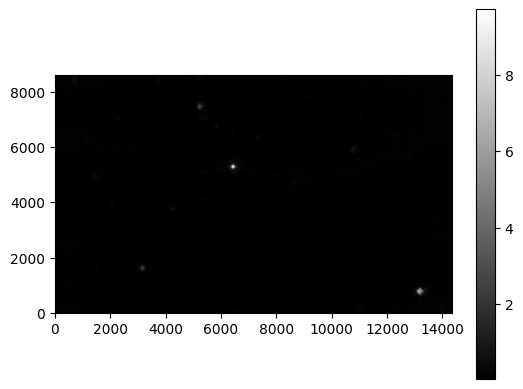

In [15]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

# plt.savefig('./sep-tutorial-figures/background_rms.png', bbox_inches='tight')
plt.show()

In [16]:
# subtract the background
data_sub = sci_data - bkg

In [17]:
# default is 300000
# sep.set_extract_pixstack(400000)

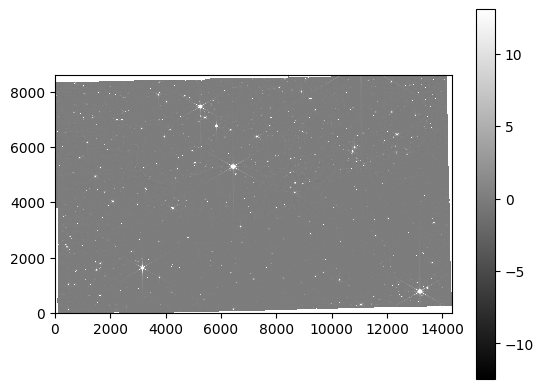

In [18]:
# show the data sub background noise
m, s = np.nanmean(data_sub), np.nanstd(data_sub)
plt.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

# plt.savefig('./sep-tutorial-figures/background_rms.png', bbox_inches='tight')
plt.show()

In [19]:
thresh_scalar = 10
objects = sep.extract(data_sub, thresh_scalar, err=bkg.globalrms)

In [20]:
# how many objects were detected
print(f" Found {len(objects)} objects at the threshold {thresh_scalar} * err")

 Found 12007 objects at the threshold 10 * err


In [21]:
from matplotlib.patches import Ellipse

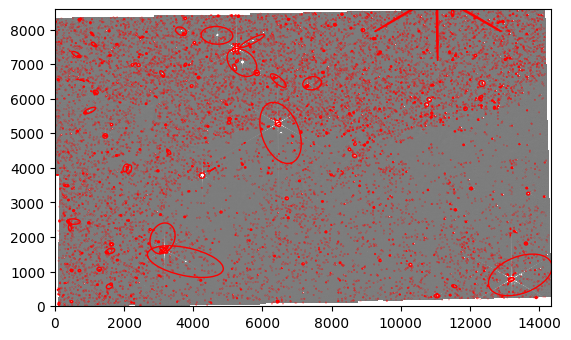

In [22]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.nanmean(data_sub), np.nanstd(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

# plt.savefig('./sep-tutorial-figures/object_detection.png', bbox_inches='tight')
plt.show()

In [23]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [24]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 36.589886 +/- 6.059121
object 1: flux = 11.585197 +/- 3.421581
object 2: flux = 249.575570 +/- 15.801828
object 3: flux = 36.325957 +/- 6.037201
object 4: flux = 474.404164 +/- 21.783642
object 5: flux = 15.155003 +/- 3.908605
object 6: flux = 56.966824 +/- 7.555762
object 7: flux = 80.441002 +/- 8.975719
object 8: flux = 21.400567 +/- 4.639337
object 9: flux = 15.415445 +/- 3.941891


In [25]:
print(np.nanmin(flux), np.nanmax(flux))

7.999049682617189 72769.94941894533


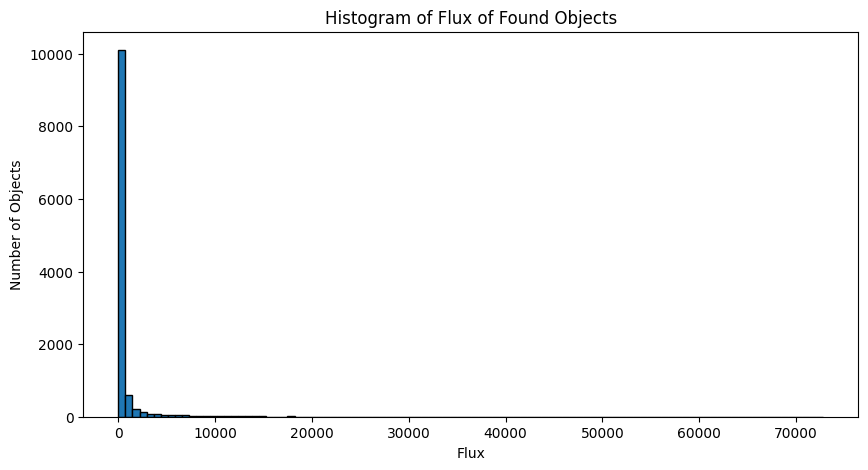

In [26]:
# create histogram with bins
num_bins = 101  # number of bins minus one because this defines the boundary numbers
histmin = np.floor(np.nanmin(flux))
histmax = np.ceil(np.nanmax(flux))

# make the limits of the bins with np.arange (makes a np from histmin -> histmax with steps of width)
bins = np.linspace(histmin, histmax, num_bins)

# plot the data as a histogram
plt.figure(figsize=(10,5))  # adujust figsize
plt.hist(flux, bins=bins, edgecolor="k")
plt.title("Histogram of Flux of Found Objects")
plt.xlabel("Flux")
plt.ylabel("Number of Objects")
# plt.savefig("cj2-prompt9.pdf", bbox_inches="tight")
plt.show()

Zoomed in on the y-axis

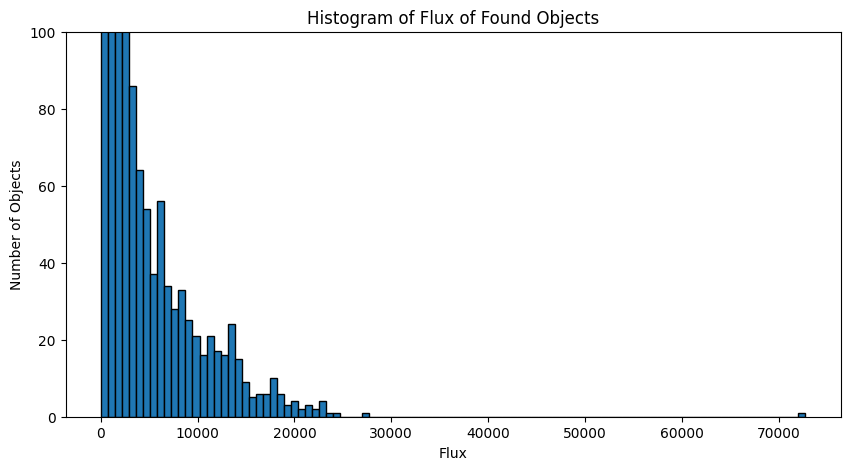

In [27]:
# create histogram with bins
num_bins = 101  # number of bins minus one because this defines the boundary numbers
histmin = np.floor(np.nanmin(flux))
histmax = np.ceil(np.nanmax(flux))

# make the limits of the bins with np.arange (makes a np from histmin -> histmax with steps of width)
bins = np.linspace(histmin, histmax, num_bins)

# plot the data as a histogram
plt.figure(figsize=(10,5))  # adujust figsize
plt.hist(flux, bins=bins, edgecolor="k")
plt.title("Histogram of Flux of Found Objects")
plt.xlabel("Flux")
plt.ylabel("Number of Objects")
plt.ylim(0, 100)
# plt.savefig("cj2-prompt9.pdf", bbox_inches="tight")
plt.show()

In [28]:
flux_mean = np.nanmean(sci_data)
flux_median = np.nanmedian(sci_data)
flux_std = np.nanstd(sci_data)

print(f"The mean of the flux is {flux_mean:.5f}")
print(f"The median of the flux is {flux_median:.5f}")
print(f"The standard deviation of the flux is {flux_std:.5f}")

The mean of the flux is 1.67565
The median of the flux is 1.22717
The standard deviation of the flux is 12.82266


Testing for outliers using Chauvenet's criterion

In [29]:
from scipy.special import erf

In [30]:
def event_probability(x, mu=0.0, s=1.0):
    # x is the value of the event
    # mu is the gaussian mean
    # s is the gaussian std

    # z is how many sigma x is from the mean
    z = np.fabs( (x-mu) / s )

    # the erf is the primitive or (anti-derivative) of
    # the gaussian function, it's value is directly related
    # to the area under the gaussian curve, and therefore probabilities
    return 1.0 - erf( z / np.sqrt(2) )

In [31]:
def chauvenet_critierion(prior_measurements, outlier):
    # prior measurements is our set of previous measurements
    # outlier is the value we want to check

    # return True if the outlier can be discard
    # false otherwise

    # compute the mean and std if prior measurements
    # and assume these are representative of a the gaussian
    mean = np.nanmean(prior_measurements)
    std = np.nanstd(prior_measurements)

    # compute the probability of the outlier
    outlier_probability = event_probability(outlier, mu=mean, s=std)

    # get number of events, including the outlier
    N = len(prior_measurements) + 1

    # check Chauvenet's criterion
    if N * outlier_probability < 0.5:
        # reject the outlier
        return True
    
    return False

In [32]:
outliers = []
for i in range(len(objects)):
    if chauvenet_critierion(flux, flux[i]):
        outliers.append(((objects['x'][i], objects['y'][i]), flux[i], i))

for o_position, o_flux , _ in outliers:
    print(f"We reject the outlier = {o_flux} at {o_position} for N = {len(objects)}")

We reject the outlier = 18615.266157836915 at (np.float64(10881.29290541456), np.float64(269.7834959762395)) for N = 12007
We reject the outlier = 17960.04649993896 at (np.float64(9973.090395019906), np.float64(340.7630943061298)) for N = 12007
We reject the outlier = 15796.62137786865 at (np.float64(10284.597343854526), np.float64(377.80738297428803)) for N = 12007
We reject the outlier = 22915.932552795413 at (np.float64(12108.378718061364), np.float64(395.13056928066175)) for N = 12007
We reject the outlier = 13144.440857849122 at (np.float64(5382.733408714631), np.float64(485.4896737977473)) for N = 12007
We reject the outlier = 14281.067619781494 at (np.float64(11711.4137574786), np.float64(492.32829910891405)) for N = 12007
We reject the outlier = 12850.279991760252 at (np.float64(3222.729208675367), np.float64(582.188494597973)) for N = 12007
We reject the outlier = 24508.824942016603 at (np.float64(12142.627388416686), np.float64(645.4472845427638)) for N = 12007
We reject the 

In [33]:
print(f"We identified {len(outliers)} outliers")

outlier_flux = np.array([o_flux for _, o_flux, _ in outliers])
outlier_i = np.array([i for _, _, i in outliers])

largest_o = outliers[np.argmax(outlier_flux)]
largest_o_flux = largest_o[1]
largest_o_position = largest_o[0]
largest_o_i = largest_o[2]

print(f"The largest flux is {largest_o_flux} at position ({largest_o_position[0]:.4f}, {largest_o_position[1]:.4f}).")

sigmas_away = np.fabs(flux_mean - largest_o_flux) / flux_std

print(f"The largest outlier is {sigmas_away:.4f} sigmas away.")

We identified 183 outliers
The largest flux is 72769.94941894533 at position (13195.3555, 788.9178).
The largest outlier is 5674.9730 sigmas away.


C:\Users\dylan\AppData\Local\Temp\ipykernel_24816\4083642885.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


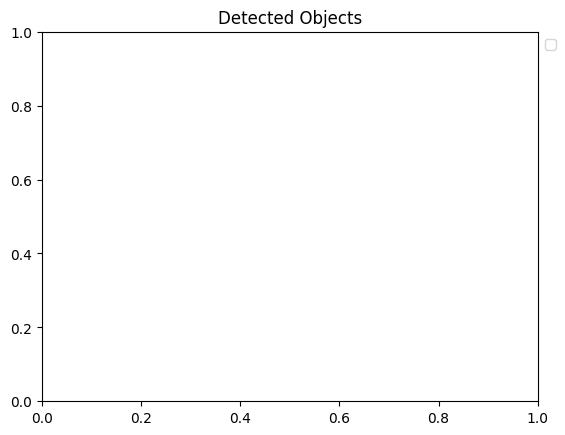

In [34]:
# plot background-subtracted image
# fig, ax = plt.subplots(figsize=(10,10))
m, s = np.nanmean(data_sub), np.nanstd(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object

largest_flux_legend = False
outlier_legend = False
object_legend = False

for i in range(len(objects)):
    
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
            width=6*objects['a'][i],
            height=6*objects['b'][i],
            angle=objects['theta'][i] * 180. / np.pi)
    
    if i == largest_o_i:
        e.set_edgecolor('purple')
        if not largest_flux_legend:
            e.set_label('Largest Outlier')
            largest_flux_legend = True
    elif i in outlier_i:
        e.set_edgecolor('green')
        if not outlier_legend:
            e.set_label('Outlier')
            outlier_legend = True
    else:
        e.set_edgecolor('red')
        if not object_legend:
            e.set_label('Detected Object')
            object_legend = True
    
    e.set_facecolor('none')
    ax.add_artist(e)

plt.title("Detected Objects")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.savefig('./sep-tutorial-figures/object_detection.png', bbox_inches='tight')
plt.show()

In [35]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

Uncomment the following cell to reproject the images

In [36]:
# jwst_folder = './Data/MAST_2025-06-08T1833/JWST'

# # ---------------------------------
# # 1. Load your reference image
# #    This will define the WCS and shape for all others
# # ---------------------------------
# file_reference = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits" # [PATH TO YOUR clear-f090w FITS FILE HERE]
# with fits.open(file_reference) as hdulist:
#     # For JWST i2d images, 'SCI' is commonly the science extension
#     ref_header = hdulist['SCI'].header
#     ref_data = hdulist['SCI'].data

# ref_data = ref_data.astype(np.float32)

# # Create a WCS object from the reference
# ref_wcs = WCS(ref_header)

# # This shape will be used for all reprojected images
# output_shape = ref_data.shape

# # ---------------------------------
# # 2. Reproject the other images
# # ---------------------------------
# fname1 = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits" # [PATH TO OTHER FITS FILE HERE]
# fname2 = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits" # [PATH TO OTHER FITS FILE HERE]
# fname3 = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits" # [PATH TO OTHER FITS FILE HERE]
# fname4 = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits" # [PATH TO OTHER FITS FILE HERE]
# fname5 = jwst_folder + "/" + "jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits" # [PATH TO OTHER FITS FILE HERE]

# other_filenames = [
#     fname1,
#     fname2,
#     fname3,
#     fname4,
#     fname5,
# ]

# # Reproject all other files according to the reference
# for fname in other_filenames:
#     with fits.open(fname) as hdulist:
#         data = hdulist['SCI'].data
#         header = hdulist['SCI'].header
#         wcs_in = WCS(header)

#     data = data.astype(np.float32)
    
#     # Reproject this image onto the reference WCS
#     # reproject_interp returns (reprojected_data, footprint)
#     reprojected_data, footprint = reproject_interp(
#         (data, wcs_in),
#         ref_wcs,
#         shape_out=output_shape,
#         block_size='auto'
#     )

#     # Optionally, update the header to match the reference WCS
#     # so that the new FITS is self-consistent
#     new_header = ref_header.copy()

#     # Save the new file
#     out_name = fname.replace('.fits', '_reproj.fits')
#     hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
#     hdu.writeto(out_name, overwrite=True)
#     print(f"Reprojected {fname} -> {out_name}")

In [37]:
jwst_folder = './Data/MAST_2025-06-08T1833/JWST'

# in wavelength order
fname1 = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits" # [PATH TO OTHER FITS FILE HERE]
fname2 = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits" # [PATH TO OTHER FITS FILE HERE]
fname3 = jwst_folder + "/" + "jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits" # [PATH TO OTHER FITS FILE HERE]
fname4 = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits" # [PATH TO OTHER FITS FILE HERE]
fname5 = jwst_folder + "/" + "jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits" # [PATH TO OTHER FITS FILE HERE]


other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# in wavelength order
reproj_filter_names = ['clear-f187n',
                       'clear-f200w',
                       'f444w-f470n',
                       'clear-f335m',
                       'clear-f444w',
                       ]

all_filter_data = {}

all_filter_data['clear-4090w'] = sci_data

for i, fname in enumerate(other_filenames):
    with fits.open(fname) as hdulist:
        all_filter_data[reproj_filter_names[i]] = hdulist['SCI'].data.astype(np.float32)

In [38]:
print(all_filter_data.keys())

dict_keys(['clear-4090w', 'clear-f187n', 'clear-f200w', 'f444w-f470n', 'clear-f335m', 'clear-f444w'])


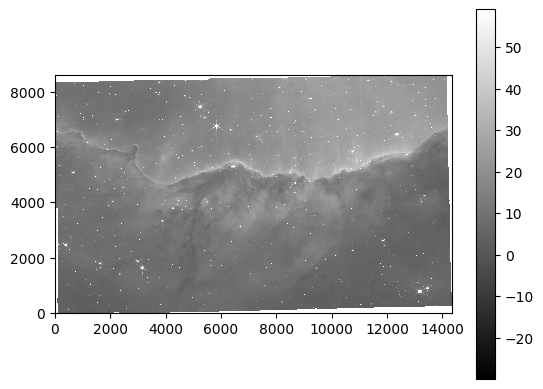

In [39]:
# show the image
# plt.figure(figsize=(10, 10))

curr_data = all_filter_data[reproj_filter_names[0]]

m, s = np.nanmean(curr_data), np.nanstd(curr_data)
plt.imshow(curr_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

# plt.savefig('./sep-tutorial-figures/fits_image.png', bbox_inches='tight')
plt.show()

In [83]:
def rescale_image(data, vmin=0.001, vmax=None):
    # copy the data to avoid accidentaly overwriting it
    data_tmp = data.copy()

    # compute the mean value over all data, excluding NaN (Not a Number)
    m = np.nanmean(data_tmp)

    # any data points below vpmin is assigned the value vpmin
    # any data points above vpmax is assigned the value vpmax
    vpmin = vmin * m
    data_tmp[data_tmp < vpmin] = vpmin

    if vmax is not None:
        vpmax = vmax * m
        data_tmp[data_tmp > vpmax] = vpmax

    # apply log-scale
    data_tmp = np.log10(data_tmp)

    # scale between 0 and 1
    dmin = np.nanmin(data_tmp)
    dmax = np.nanmax(data_tmp)

    print(dmin, dmax)

    data_tmp = (data_tmp - dmin)/(dmax-dmin)

    data_tmp = data_tmp.astype(np.float32)

    return data_tmp

-1.8353144 4.367481


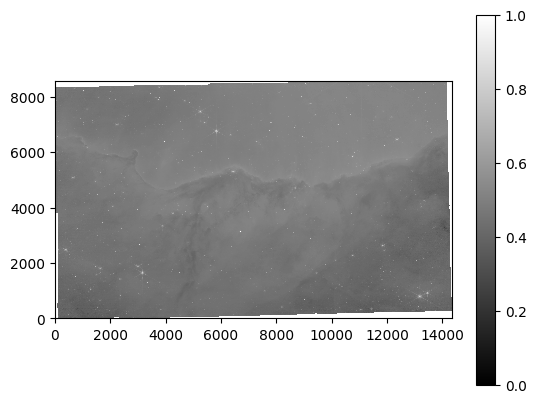

In [84]:
# show the image
# plt.figure(figsize=(10, 10))

test_data = rescale_image(curr_data)

plt.imshow(test_data, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

# plt.savefig('./sep-tutorial-figures/fits_image.png', bbox_inches='tight')
plt.show()

In [85]:
from matplotlib import colors as mcolors

In [86]:
# get filter colors
filter_colors = [mcolors.to_rgb('blue'),
mcolors.to_rgb('cyan'),
mcolors.to_rgb('green'),
mcolors.to_rgb('yellow'),
mcolors.to_rgb('orange'),
mcolors.to_rgb('red')
]

filter_colors

[(0.0, 0.0, 1.0),
 (0.0, 1.0, 1.0),
 (0.0, 0.5019607843137255, 0.0),
 (1.0, 1.0, 0.0),
 (1.0, 0.6470588235294118, 0.0),
 (1.0, 0.0, 0.0)]

In [87]:
filter_names = list(all_filter_data.keys())
filter_names

['clear-4090w',
 'clear-f187n',
 'clear-f200w',
 'f444w-f470n',
 'clear-f335m',
 'clear-f444w']

In [88]:
np.expand_dims(rescale_image(all_filter_data['clear-f187n']), axis=2).shape

-1.8353144 4.367481


(8582, 14339, 1)

In [ ]:
width, height = sci_data.shape
channels = 3

compiled_image = np.zeros((width, height, channels))
for i, name in enumerate(filter_names):
    compiled_image += np.expand_dims(rescale_image(all_filter_data[name]), axis=2) * filter_colors[i]

compiled_image /= 6


-2.7758179 3.7561843
-1.8353144 4.367481
-2.587539 3.4791481
-2.4208217 3.8690538


In [ ]:
compiled_image.shape

In [ ]:
compiled_image = compiled_image.astype(np.float32)

plt.imshow(compiled_image, interpolation='nearest', origin='lower')

# plt.savefig('./sep-tutorial-figures/fits_image.png', bbox_inches='tight')
plt.show()

In [ ]:
all_filter_data.keys()

In [ ]:
### Let's combine the data into a single object, where each layer will correspond to a color
three_filter = np.zeros((sci_data.shape[0],sci_data.shape[1],3), dtype=np.float32)

three_filter[:,:,0] = rescale_image(all_filter_data['clear-4090w']) #red is filter 'clear-4090w'
three_filter[:,:,1] = rescale_image(all_filter_data['clear-f187n']) #green is filter 'clear-f187n'
three_filter[:,:,2] = rescale_image(all_filter_data['clear-f200w']) #blue is filter 'clear-f200w'

In [ ]:
print(np.shape(three_filter))
print(np.nanmin(three_filter), np.nanmax(three_filter))

In [ ]:
plt.imshow(three_filter, interpolation='nearest', origin='lower')

# plt.savefig('./sep-tutorial-figures/fits_image.png', bbox_inches='tight')
plt.show()

In [ ]:
### Let's combine the data into a single object, where each layer will correspond to a color
six_filter = np.zeros((sci_data.shape[0],sci_data.shape[1],3), dtype=np.float32)

for i in range(0, len(filter_names), 2):
    six_filter[:, :, i//2] = rescale_image(all_filter_data[filter_names[i]]) * 0.5 + rescale_image(all_filter_data[filter_names[i+1]]) * 0.5

In [ ]:
plt.imshow(six_filter, interpolation='nearest', origin='lower')

# plt.savefig('./sep-tutorial-figures/fits_image.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(six_filter[100, : ,0])
plt.show()

print(np.nanmin(six_filter), np.nanmax(six_filter))
print(np.nanmean(six_filter), np.nanstd(six_filter))

In [105]:
# interpret 6 filters as hsv
hsv_six_filter = mcolors.hsv_to_rgb(six_filter)

MemoryError: Unable to allocate 469. MiB for an array with shape (8582, 14339) and data type float32

MemoryError: Unable to allocate 1.38 GiB for an array with shape (8582, 14339, 3) and data type float32

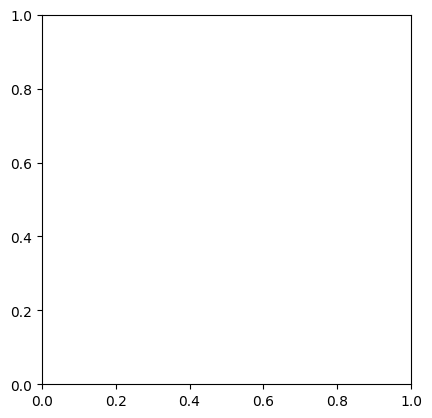

In [106]:
plt.imshow(hsv_six_filter, interpolation='nearest', origin='lower')

# plt.savefig('./sep-tutorial-figures/fits_image.png', bbox_inches='tight')
plt.show()